In [1]:
# General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import perf_counter as time
import numpy as np
import random as rnd
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, accuracy_score, 
                             make_scorer, recall_score, f1_score, precision_score)
from sklearn.model_selection import StratifiedKFold
import os
from analysis_training.preprocessing_utils import drop_features_, fill_nan_values
import analysis_training
import analysis_training.neural_networks.model_definition as models
import analysis_training.neural_networks.nn_utils as nn_utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### The code reads a compressed CSV dataset from a specified file path using pandas. It focuses on preparing the dataset for classification tasks by setting the target variable, removing irrelevant features and providing key insights such as the dataset's shape, information and the count of NULL & unique values per column.
***Tasks***: 
- Reads a compressed CSV dataset using pandas.
- Defines the target variable for either multi-class or binary classification.
- Removes irrelevant features from the dataset.
- Prints the original shape of the dataset.
- Displays dataset information, including data types.
- Prints the number of NULL values per column.
- Prints the number of unique values per column.

Original shape of Dataset: (1215890, 106)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Columns: 106 entries, SrcId to Label
dtypes: float64(66), int64(24), object(16)
memory usage: 983.3+ MB

Number of NULL values per column:
SrcId             0
Rank              0
StartTime         0
LastTime          0
Trans             0
              ...  
TcpRtt            0
SynAck            0
AckDat            0
TcpOpt       938654
Label             0
Length: 106, dtype: int64

Number of unique values per column:
SrcId             1
Rank         467717
StartTime     32888
LastTime      32828
Trans             1
              ...  
TcpRtt        18745
SynAck         3896
AckDat        23870
TcpOpt            7
Label             2
Length: 106, dtype: int64


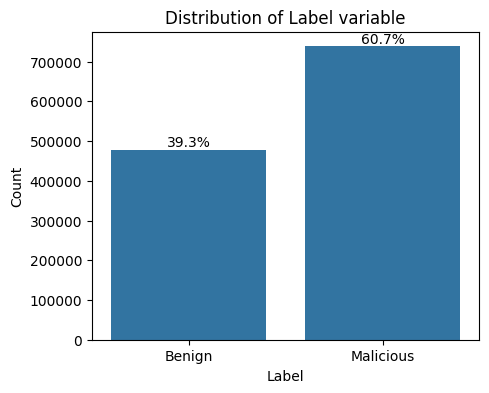

In [2]:
# dataset_fpath = '../../../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = analysis_training.load_dataset()

# Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of Dataset: {nidd_dataset.shape}")

print(f'\nDataset Information:')
nidd_dataset.info()

# print(f'\nDataset Description:')
# print(nidd_dataset.describe())

print(f'\nNumber of NULL values per column:')
print(nidd_dataset.isnull().sum())

print(f'\nNumber of unique values per column:')
print(nidd_dataset.nunique())

plt.figure(figsize=(5, 4))
ax = sns.countplot(x=TARGET, data=nidd_dataset)
total_count = len(nidd_dataset)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title(f'Distribution of {TARGET} variable')
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.show()

### Dropping columns based on specified threshold values
***Tasks***:
- Initializes dictionaries to store dropped features and processing time.
- Drops columns with more than 95% NaN values from the dataset.
- Drops columns with more than 95% zero values from the updated dataset.
- Drops constant columns from the further cleaned dataset.
- Calculates and prints the time taken for the dropping features step.

In [3]:
# Dictionary to store dropped features based on different criteria
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}

# Dictionary to store processing time
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Time <Filling NaNs>": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.,
                   "Time <Data preprocessing>": 0.,
                   "Time <Model training>": 0.,
                   "Time <Model testing>": 0.,
                   "Time <K-Fold cross validation>": 0.,}

# Record the starting time for dropping features based on "bad" values
t0 = time()

# Dropping columns with more than 95% NaN values
threshold_nans = 0.95 * nidd_dataset.shape[0]
columns_Nan_to_drop = nidd_dataset.columns[nidd_dataset.isna().sum() > threshold_nans]
features_dropped["Nan columns"].extend(columns_Nan_to_drop)
nidd_dataset_cleaned_nan = nidd_dataset.drop(columns=columns_Nan_to_drop)
# Alternatively, you can use:
# nidd_dataset_cleaned_nan = nidd_dataset.dropna(thresh=ceil(1 - threshold_nans), axis=1)
print(f"After dropping NaN columns: {nidd_dataset_cleaned_nan.shape}")

# Dropping columns with more than 95% zero values
threshold_zeros = 0.95 * nidd_dataset.shape[0]
zero_counts = nidd_dataset_cleaned_nan.apply(lambda col: (col == 0).sum())
columns_zeros_to_drop = zero_counts[zero_counts > threshold_zeros].index
features_dropped["Zero columns"].extend(columns_zeros_to_drop)
nidd_dataset_cleaned_zeros = nidd_dataset_cleaned_nan.drop(columns_zeros_to_drop, axis=1)
print(f"After dropping NaN & Zero columns: {nidd_dataset_cleaned_zeros.shape}")

# Dropping constant columns
constant_columns = nidd_dataset_cleaned_zeros.columns[nidd_dataset_cleaned_zeros.nunique() == 1]
features_dropped["Constant columns"].extend(constant_columns)
nidd_dataset_cleaned = nidd_dataset_cleaned_zeros.drop(columns=constant_columns)
print(f"After dropping NaN & Zero & Constant columns: {nidd_dataset_cleaned.shape}")

# Record the ending time for dropping features based on "bad" values
t1 = time()

# Calculate and print the time taken for the dropping features step
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = t1 - t0
print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
# preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time
# print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)
Time <Dropping features based on a threshold `bad` values>: 2.181 seconds


### Filling NaN values and Encoding categorical columns using Label Encoder
***Tasks***:

**1. Filling NaN Values:**
   - Identify numeric and categorical columns in the cleaned dataset.
   - Fill NaN values in numeric columns with the mean of each column.
   - Fill NaN values in categorical columns with the mode of each column.
   - Print the time taken for filling NaN values.

**2. Encoding Categorical Features:**
   - Use LabelEncoder to transform categorical columns into numerical representations.
   - Print the time taken for encoding categorical features.


In [4]:
# Record the starting time for filling NaN values
t0 = time()

# Get numeric and categorical columns
numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

# Fill NaN values in numeric columns with mean
numeric_cols_mean = nidd_dataset_cleaned[numeric_cols].mean()
nidd_dataset_cleaned[numeric_cols] = nidd_dataset_cleaned[numeric_cols].fillna(numeric_cols_mean)

# Fill NaN values in categorical columns with mode
# iloc[0] is used to get the first element of the series in case there is more than one mode.
categorical_cols_mode = nidd_dataset_cleaned[categorical_cols].mode().iloc[0]
nidd_dataset_cleaned[categorical_cols] = nidd_dataset_cleaned[categorical_cols].fillna(categorical_cols_mode)

# Record the ending time for filling NaN values
t1 = time()
preprocessing_d["Time <Filling NaNs>"] = t1 - t0

# Print the time taken for filling NaN values
print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
# preprocessing_d["Filling NaNs"] = fill_time
# print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# Record the starting time for encoding categorical features
t0 = time()

# Encoding categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

# Record the ending time for encoding categorical features
t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

# Print the time taken for encoding categorical features
print(f"Time <Encoding categorical features>: {preprocessing_d['Time <Encoding categorical features>']:.3f} seconds")

Time <Filling NaNs>: 1.976 seconds
Time <Encoding categorical features>: 1.480 seconds


### Dropping features based on the Pearson Correlation Matrix

***Tasks***:
- Define the target column for correlation analysis (e.g. TARGET).
- Calculate the correlation matrix using the Pearson method.
- Set a correlation threshold for feature selection (e.g. 0.9).
- Identify pairs of features with high correlation.
- Initialize a set to store features to be dropped (avoiding duplicates).
- Iterate through the pairs of highly correlated features.
   - Check if the correlation signs are the same.
   - Keep the feature with the higher absolute correlation with the target variable.
   - Add the selected feature to the set of features to be dropped.
- Drop the identified features with high correlation from the cleaned dataset.
- Update the total preprocessing time for feature selection.
- Print the final shape of the cleaned DataFrame after removing correlated features.
- Visualize the correlation matrix with a heatmap.

Final shape of cleaned DataFrame after removing correlated features based on Pearson method: (1215890, 36)


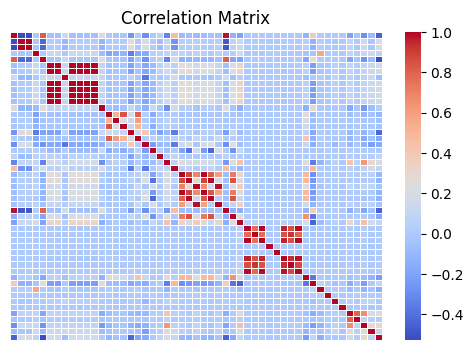

In [5]:
t0 = time()

# Define the target column for correlation analysis
target_col = nidd_dataset_cleaned.columns[-1] # eq: TARGET

# Calculate the correlation matrix using Pearson method
correlation_matrix = nidd_dataset_cleaned.corr(method='pearson')

# Set the correlation threshold for feature selection
corr_threshold = 0.9

# Identify pairs of features with high correlation
high_corr_pairs = correlation_matrix.iloc[:, :-1].abs() > corr_threshold

# Initialize a set to store features to be dropped (avoiding duplicates)
features_to_drop = set()

# Iterate through the pairs of highly correlated features
for feature_on_col in high_corr_pairs.columns:
    for feature_in_row in high_corr_pairs.index[high_corr_pairs[feature_on_col]]:
        if feature_on_col != feature_in_row:  # Avoid comparisons between the same pairs
            # Get the correlation values for each feature against the target variable
            feature_in_row_cor_val = correlation_matrix.loc[feature_in_row, target_col]
            feature_on_col_cor_val = correlation_matrix.loc[feature_on_col, target_col]
            
            # Check if the correlation signs are the same
            same_corellation_sign = feature_in_row_cor_val * feature_on_col_cor_val > 0
            
            # If the signs are the same, keep the feature with the higher absolute correlation
            if same_corellation_sign:
                if abs(feature_in_row_cor_val) > abs(feature_on_col_cor_val):
                    features_to_drop.add(feature_on_col)
                else:
                    features_to_drop.add(feature_in_row)

# Drop the identified features with high correlation
nidd_dataset_filtered = nidd_dataset_cleaned.drop(columns=list(features_to_drop))

t1 = time()

# Update the total preprocessing time for feature selection
preprocessing_d["Time <Feature selection>"] += t1 - t0

# Print the final shape of the cleaned DataFrame after removing correlated features
print(f"Final shape of cleaned DataFrame after removing correlated features based on Pearson method: {nidd_dataset_filtered.shape}")

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
            fmt='.2f', xticklabels=False, yticklabels=False,
            linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### ANOVA F-scores are calculated for each feature and a DataFrame is created to store feature names & their corresponding F-scores. The top features are then selected based on the highest F-scores.
***Tasks***:
- Separate features (X) and the target variable (y) from the filtered dataset.
- Calculate ANOVA F-scores for each feature.
- Create a DataFrame to store feature names and their corresponding F-scores.
- Sort the DataFrame based on F-scores in descending order.
- Select the top 10 features based on ANOVA F-scores.
- Print the top 10 features and their corresponding F-scores.
- Print the time taken for feature selection.

In [6]:
# Separate features (X) and target variable (y)
X = nidd_dataset_filtered.drop(columns=[target_col])
y = nidd_dataset_filtered[target_col]

# Record the starting time for ANOVA F-score feature selection
t0 = time()

# Calculate ANOVA F-scores
f_scores, _ = f_classif(X, y)
# Create a DataFrame to store feature names and their corresponding F-scores
results_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})
# Sort the DataFrame based on F-scores in descending order
results_df = results_df.sort_values(by='F-Score', ascending=False)

# Record the ending time for ANOVA F-score feature selection
t1 = time()
preprocessing_d["Time <Feature selection>"] += t1-t0

# Select the top 10 features based on ANOVA F-scores
top_10_features = results_df.head(10)

# Print the top 10 features and their corresponding F-scores
print("Top 10 Features based on ANOVA F-scores:")
for index, row in top_10_features.iterrows():
    print(f"{row['Feature']}: {row['F-Score']}")

# Print the time taken for feature selection
print(f"\nTime <Feature selection>: {preprocessing_d['Time <Feature selection>']:.3f} seconds")

Top 10 Features based on ANOVA F-scores:
Seq: 469849.6390666038
Offset: 319314.40971959295
sTtl: 271902.447512305
AckDat: 114843.30885848559
Dir: 67629.15152188136
StartTime: 54826.22943189787
dIpId: 53749.31118614725
TcpRtt: 48169.83238437568
dTtl: 40155.94625566492
sMeanPktSz: 38473.44797186211

Time <Feature selection>: 5.536 seconds


### Applying Z-Normalization to the selected numerical features. Using Ordinal Encoder to transform categorical columns into numerical representations and Label Endoder to tranform target categorical column into numerical representation. Creating an appropriate pipeline that includes the appropriate preprocessors(e.g. SimpleImputer, StandardScaler) and fitting - transform the pipeline on the dataset. 
***Tasks***:
- Extract the top 10 feature columns from the DataFrame based on ANOVA F-scores.
- Extract the target variable and feature values from the original dataset based on the top 10 features.
- Split the dataset into training and testing sets.
- Identify numeric and categorical features within the top 10 features.
- Create transformers for numeric and categorical features, including imputation and scaling for numeric features and imputation and encoding for categorical features.
- Create a ColumnTransformer to apply different transformers to numeric and categorical features.
- Create a pipeline(that includes preprocessing) in which the input data is fitted and transformed.
- Record the starting time for preprocessing the input data.
- Fit - Transform the pipeline on the dataset(input data).
- Fit - Transform the Label Encoder on the target categorical column.
- Print the time taken for data preprocessing.

In [7]:
# Extract top 10 feature columns from the DataFrame
top_10_features_cols = top_10_features['Feature'].tolist()

# Extract target variable and features' values based on top 10 features
target = nidd_dataset[TARGET]
features = nidd_dataset[top_10_features_cols]

# Identify numeric and categorical features within the top 10 features
numeric_features = list(set(numeric_cols) & set(top_10_features_cols))  # Numeric features
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))  # Categorical features

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation using mean
    ('scaler', StandardScaler())  # Standard scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation using most frequent value
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))  # Ordinal encoding
])

# Create a ColumnTransformer to apply different transformers to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Apply numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)  # Apply categorical transformer to categorical features
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor)  # Include data preprocessing in the pipeline
])

t0 = time()  # Record starting time for data preprocessing

# Fit and transform the dataset
transformed_dataset = pipeline.fit_transform(features)

# Encode the target variable
encoded_target = label_encoder.fit_transform(target)

t1 = time()  # Record ending time for preprocessing
preprocessing_d["Time <Data preprocessing>"] = t1-t0  # Record the time taken for preprocessing

# Print the time taken for preprocessing
print(f"Time <Data preprocessing>: {preprocessing_d['Time <Data preprocessing>']:.3f} seconds")

Time <Data preprocessing>: 1.069 seconds


In [10]:
import joblib
with open('../../../models/CNN_LSTM/CNN_LSTM_preprocessor.pkl', 'wb') as file:
     joblib.dump(pipeline, file)

### Training - Testing CNN-LSTM Binary Classifier
***Tasks***:
1. Data Preprocessing:
- The dataset is preprocessed to be compatible with PyTorch. The input features (X_tensor) and the target labels (y_tensor) are converted into PyTorch tensors. The dataset is then split into training and testing sets using the train_test_split function from scikit-learn. These sets are further converted into PyTorch TensorDataset objects for easier handling during training and testing.

2. Model Definition and Optimization:
- The CNN_LSTM_BinaryClassifier class defines a model architecture that combines a Convolutional Neural Network (CNN) with a Long Short-Term Memory (LSTM) for binary classification. The architecture includes a convolutional layer, followed by a hyperbolic tangent (Tanh) activation function, an LSTM layer with specified hidden size and number of layers and a linear (fully connected) layer mapping the LSTM output to the desired number of output classes. Optimization is performed using the Adam optimizer (`optim.Adam`) with a specified learning rate.

3. Training Loop:
- The training loop iterates over a specified number of epochs. Within each epoch, the model is set to training mode (model.train()) and the training dataset is iterated over in batches using the train_loader. For each batch, the model computes the output predictions, calculates the loss using binary cross-entropy, performs backpropagation to update the model parameters and calculates the training accuracy.

4. Testing Loop:
- After training, the model is evaluated on the testing dataset. The model is set to evaluation mode (model.eval()) and the testing dataset is iterated over in batches using the test_loader. During testing, gradient calculation is disabled (torch.no_grad()) to save computational resources. The model predictions are compared with the true labels to calculate the testing accuracy.

5. Performance Metrics Logging:
- Throughout training and testing, the code logs the training and testing losses, as well as the training and testing accuracies, for each epoch. These metrics are typically used to monitor the performance of the model and assess its convergence and generalization capabilities.

In [11]:
X_tensor = torch.FloatTensor(transformed_dataset.reshape(-1,1,10))
y_tensor = torch.FloatTensor(encoded_target).unsqueeze(1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=rnd.seed(42))

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


in_channels = X_train.shape[1]
kernels = 16  
kernel_size = 3 
lstm_hidden_size = 8  
lstm_num_layers = 1  
classes = 1  
learning_rate = 0.001

model = models.CNN_LSTM_BinaryClassifier(input_channels=in_channels, kernels=kernels, kernel_size=kernel_size, lstm_hidden_size=lstm_hidden_size, 
                                  lstm_num_layers=lstm_num_layers, classes = classes).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 4

score_funcs = {'Accuracy': accuracy_score, 'Recall': recall_score, 'Precision': precision_score, 'F1': f1_score}

training = nn_utils.Training(model = model, optimizer = optimizer, loss_fn = criterion, device = device, score_funcs = score_funcs)
training.train(train_loader = train_loader, test_loader = test_loader, epochs = num_epochs)
results = training.results

# Calculate and print the time taken for training - testing the model
preprocessing_d["Time <Model training>"] = results['total training time']
preprocessing_d["Time <Model testing>"] = results['total testing time']
print(f"Time <Model training>: {preprocessing_d['Time <Model training>']:.3f} seconds")
print(f"Time <Model testing>: {preprocessing_d['Time <Model testing>']:.3f} seconds")

Device: cpu


|train():71| - Training - Epoch [1/4], Loss: 0.0443, Accuracy: 98.63%
|train():87| - Testing - Epoch [1/4], Loss: 0.0181, Accuracy: 99.46%
|train():71| - Training - Epoch [2/4], Loss: 0.0146, Accuracy: 99.57%
|train():87| - Testing - Epoch [2/4], Loss: 0.0101, Accuracy: 99.67%
|train():71| - Training - Epoch [3/4], Loss: 0.0099, Accuracy: 99.70%
|train():87| - Testing - Epoch [3/4], Loss: 0.0087, Accuracy: 99.69%
|train():71| - Training - Epoch [4/4], Loss: 0.0076, Accuracy: 99.77%
|train():87| - Testing - Epoch [4/4], Loss: 0.0070, Accuracy: 99.76%


Time <Model training>: 159.683 seconds
Time <Model testing>: 16.071 seconds


In [10]:
import joblib
with open("../../../models/CNN_LSTM/CNN_LSTM_model", "wb") as fp:
    joblib.dump(model.state_dict(), fp)

# import yaml
# with open('../../../src/config.yml', 'r') as file:
#     config_data = yaml.safe_load(file)

# config_data['NN']['CNN_LSTM']['input_channels'] = in_channels
# config_data['NN']['CNN_LSTM']['kernels'] = kernels
# config_data['NN']['CNN_LSTM']['kernel_size'] = kernel_size
# config_data['NN']['CNN_LSTM']['classes'] = classes
# config_data['NN']['CNN_LSTM']['lstm_hidden_size'] = lstm_hidden_size
# config_data['NN']['CNN_LSTM']['lstm_num_layers'] = lstm_num_layers

# with open('../../../src/config.yml', 'w') as file:
#     yaml.dump(config_data, file)

### Confusion Matrix and Classification Report
***Tasks***:
- Calculate the confusion matrix using the predicted and true labels from the test data.
- Plot the confusion matrix using a heatmap for better visualization.
   - Each cell represents the count of true positive instances, with text annotations.
- Generate and print the classification report, including precision, recall and F1-score for each class in the target variable.

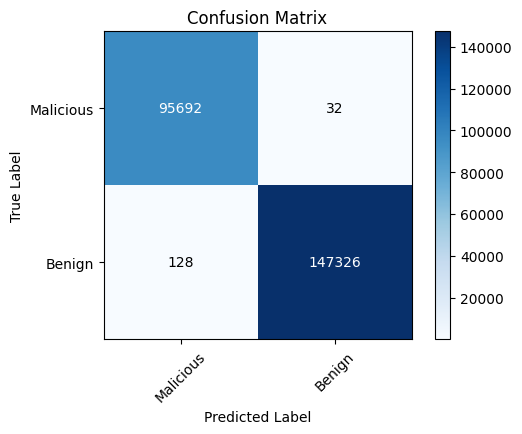

Classification Report:
               precision    recall  f1-score   support

   Malicious   0.999666  0.998664  0.999165     95820
      Benign   0.999132  0.999783  0.999457    147358

    accuracy                       0.999342    243178
   macro avg   0.999399  0.999224  0.999311    243178
weighted avg   0.999342  0.999342  0.999342    243178



In [11]:
predictions = training.final_predictions

# Convert the target variables to NumPy arrays with integer data type
y_test = np.array(y_test, dtype=int)
predictions = np.array(predictions, dtype=int)

# Calculate the confusion matrix
conf_matrix = np.array(confusion_matrix(y_test, predictions))

# Get the unique categories in the target variable
target_categories = set(nidd_dataset[TARGET])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set the ticks and labels for the x-axis and y-axis
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)

# Add text annotations to the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Generate and print the classification report
class_report = classification_report(predictions, y_test, target_names=target_categories, digits=6)
print("Classification Report:\n", class_report)


### CNN-LSTM Model's Architecture and Computational Graph Visualization

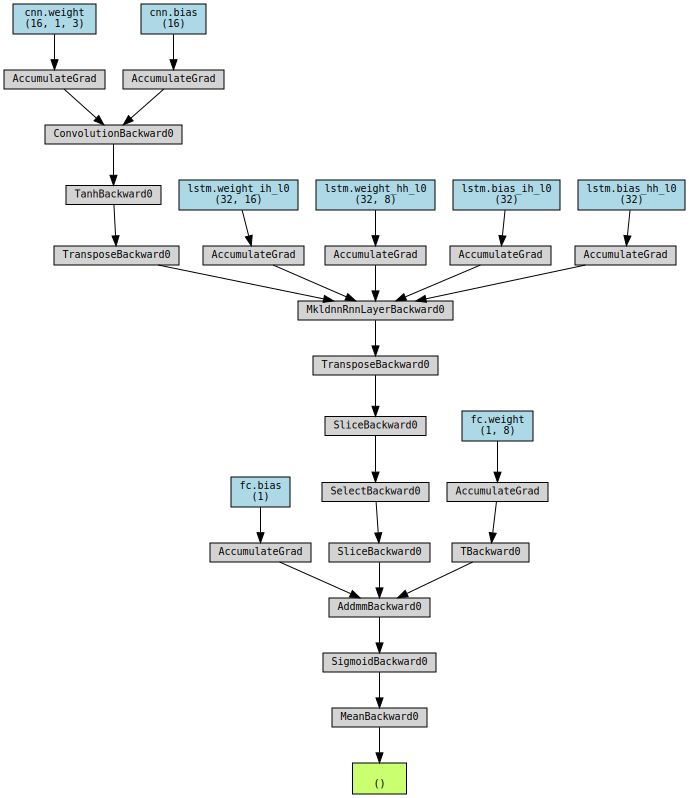

In [12]:
from torchviz import make_dot

# Initialize the model
# model = CNN_LSTM_BinaryClassifier(input_channels=in_channels, kernels=kernels, kernel_size=kernel_size, lstm_hidden_size=lstm_hidden_size, 
#                                   lstm_num_layers=lstm_num_layers, classes = classes).to(device)

# Perform a forward pass through the model to get the output
y = model(X_tensor[:1,:,:])

# Visualize the computational graph
make_dot(y.mean(), params=dict(model.named_parameters()))
# The `.mean()` function calculates the mean of the output tensor `y`, simplifying the visualization.
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

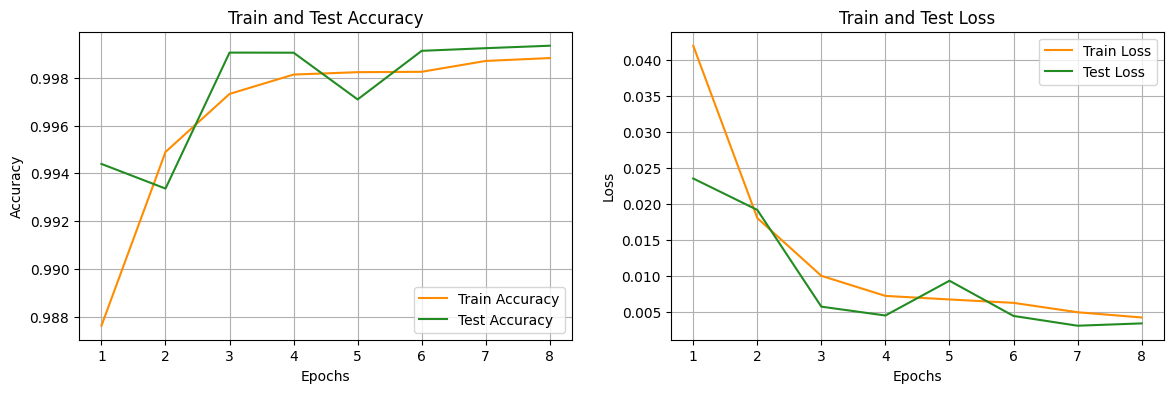

In [12]:
# Call the function to plot metrics
nn_utils.plot_metrics(results['train Accuracy'], results['train Loss'], results['test Accuracy'], results['test Loss'])

### Stratified K-Fold Cross-Validation Training and Evaluation Pipeline

#### Steps:
1. **Data Preparation:**
   - Convert input features and target labels from PyTorch tensors to NumPy arrays for compatibility with scikit-learn's cross-validation module.
   - Define the number of splits for Stratified K-Fold cross-validation.

2. **Stratified K-Fold Cross-Validation:**
   - Initialize Stratified K-Fold cross-validator with the specified number of splits.
   - Iterate over each fold and split the data into training and validation sets.
   - Create PyTorch datasets and data loaders for both training and validation sets.

3. **Model Training and Evaluation:**
   - For each fold:
     - Initialize the binary classification neural network model, loss function (Binary Cross-Entropy Loss) and optimizer (Adam).
     - Perform the training loop over multiple epochs:
       - Set the model to training mode.
       - Iterate over batches in the training set, perform forward pass, compute loss, backpropagate gradients and update weights.
       - Calculate training accuracy and loss for each epoch.
     - Perform the validation loop over multiple epochs:
       - Set the model to evaluation mode.
       - Iterate over batches in the validation set, calculate validation loss and accuracy without updating weights.
     - Store training and validation metrics for each fold.

#### Output:
- For each fold, the code prints training and validation metrics (loss and accuracy) for each epoch.
- Additionally, it collects and stores these metrics for further analysis or visualization.

#### Note:
- This pipeline allows for robust evaluation of the model's performance across different folds, helping to mitigate overfitting and provide more reliable performance estimates.

In [13]:
# Convert tensors to NumPy arrays
X_numpy = X_tensor.numpy()
y_numpy = y_tensor.squeeze(1).numpy()  # Squeeze the extra dimension

# Define the number of splits for Stratified K-Fold cross-validation
num_splits = 3  

# Initialize Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Create dictionaries to store metrics for each fold
fold_metrics = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}


t0 = time()  # Record the starting time for K-Fold cross-validation
# Iterate over folds
for fold, (train_indices, val_indices) in enumerate(skf.split(X_numpy, y_numpy)):
    
    print(f'\nFold {fold + 1}/{num_splits}')

    # Split data into training and validation sets
    X_train_fold, X_val_fold = torch.FloatTensor(X_numpy[train_indices]), torch.FloatTensor(X_numpy[val_indices])
    y_train_fold, y_val_fold = torch.FloatTensor(y_numpy[train_indices]).unsqueeze(1), torch.FloatTensor(y_numpy[val_indices]).unsqueeze(1)

    # Create datasets and data loaders for training and validation sets
    train_dataset_fold = TensorDataset(X_train_fold, y_train_fold)
    val_dataset_fold = TensorDataset(X_val_fold, y_val_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = models.CNN_LSTM_BinaryClassifier(input_channels=in_channels, kernels=kernels, kernel_size=kernel_size, lstm_hidden_size=lstm_hidden_size, 
                                  lstm_num_layers=lstm_num_layers, classes = classes).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store metrics for this fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()

        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Iterate over batches in the training set
        for inputs, labels in train_loader_fold:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader_fold)
        accuracy = correct_predictions / total_samples
        
        # if (epoch + 1) % 5 == 0:
        print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Append metrics to lists
        train_losses.append(average_loss)
        train_accuracies.append(accuracy)

        # Validation loop
        model.eval()

        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        # Disable gradient calculation during validation
        with torch.no_grad():
            # Iterate over batches in the validation set
            for val_inputs, val_labels in val_loader_fold:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                # Calculate accuracy
                val_predicted = (val_outputs > 0.5).float()
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

            val_average_loss = val_loss / len(val_loader_fold)
            val_accuracy = val_correct_predictions / val_total_samples

            print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_average_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%')

            # Append metrics to lists
            val_losses.append(val_average_loss)
            val_accuracies.append(val_accuracy)

    # Store metrics for this fold in the dictionary
    fold_metrics['train_loss'].append(train_losses)
    fold_metrics['val_loss'].append(val_losses)
    fold_metrics['train_accuracy'].append(train_accuracies)
    fold_metrics['val_accuracy'].append(val_accuracies)

t1 = time() # Record the ending time for K-Fold cross-validation

# Calculate and print the time taken for K-Fold cross-validation of the model
preprocessing_d["Time <K-Fold cross validation>"] = t1 - t0
print(f"Time <K-Fold cross validation>: {preprocessing_d['Time <K-Fold cross validation>']:.3f} seconds")



Fold 1/3
Training - Epoch [1/8], Loss: 0.0434, Accuracy: 98.71%
Validation - Epoch [1/8], Loss: 0.0156, Accuracy: 99.48%
Training - Epoch [2/8], Loss: 0.0136, Accuracy: 99.60%
Validation - Epoch [2/8], Loss: 0.0091, Accuracy: 99.72%
Training - Epoch [3/8], Loss: 0.0094, Accuracy: 99.73%
Validation - Epoch [3/8], Loss: 0.0091, Accuracy: 99.72%
Training - Epoch [4/8], Loss: 0.0078, Accuracy: 99.79%
Validation - Epoch [4/8], Loss: 0.0047, Accuracy: 99.89%
Training - Epoch [5/8], Loss: 0.0078, Accuracy: 99.79%
Validation - Epoch [5/8], Loss: 0.0138, Accuracy: 99.60%
Training - Epoch [6/8], Loss: 0.0066, Accuracy: 99.82%
Validation - Epoch [6/8], Loss: 0.0054, Accuracy: 99.83%
Training - Epoch [7/8], Loss: 0.0057, Accuracy: 99.84%
Validation - Epoch [7/8], Loss: 0.0033, Accuracy: 99.89%
Training - Epoch [8/8], Loss: 0.0046, Accuracy: 99.87%
Validation - Epoch [8/8], Loss: 0.0030, Accuracy: 99.92%

Fold 2/3
Training - Epoch [1/8], Loss: 0.0474, Accuracy: 98.64%
Validation - Epoch [1/8], Los

In [ ]:
# Call the function to plot K-folds metrics
nn_utils.plot_folds_train_val_metrics(fold_metrics['train_loss'], fold_metrics['val_loss'], fold_metrics['train_accuracy'], fold_metrics['val_accuracy'], num_epochs)

### Processing times for various preprocessing steps involved in the data preparation and model training pipeline

In [14]:
# Print the preprocessing times
print("Time Report:")
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")

Time Report:
Time <Dropping features based on a threshold `bad` values>: 2.1850 seconds
Time <Filling NaNs>: 2.1414 seconds
Time <Encoding categorical features>: 1.4519 seconds
Time <Feature selection>: 5.7959 seconds
Time <Data preprocessing>: 1.1576 seconds
Time <Model training>: 244.5616 seconds
Time <Model testing>: 25.9111 seconds
Time <K-Fold cross validation>: 0.0000 seconds


: 